In [1]:
import argparse
import glob
import json
import multiprocessing
import os
import random
import re
from importlib import import_module
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset import MaskBaseDataset
from loss import create_criterion
import timm
from torch import nn

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [3]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [4]:
def grid_image(np_images, gts, preds, n=16, shuffle=False):
    batch_size = np_images.shape[0]
    assert n <= batch_size

    choices = random.choices(range(batch_size), k=n) if shuffle else list(range(n))
    figure = plt.figure(
        figsize=(12, 18 + 2)
    )  # cautions: hardcoded, 이미지 크기에 따라 figsize 를 조정해야 할 수 있습니다. T.T
    plt.subplots_adjust(
        top=0.8
    )  # cautions: hardcoded, 이미지 크기에 따라 top 를 조정해야 할 수 있습니다. T.T
    n_grid = int(np.ceil(n**0.5))
    tasks = ["mask", "gender", "age"]
    for idx, choice in enumerate(choices):
        gt = gts[choice].item()
        pred = preds[choice].item()
        image = np_images[choice]
        gt_decoded_labels = MaskBaseDataset.decode_multi_class(gt)
        pred_decoded_labels = MaskBaseDataset.decode_multi_class(pred)
        title = "\n".join(
            [
                f"{task} - gt: {gt_label}, pred: {pred_label}"
                for gt_label, pred_label, task in zip(
                    gt_decoded_labels, pred_decoded_labels, tasks
                )
            ]
        )

        plt.subplot(n_grid, n_grid, idx + 1, title=title)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image, cmap=plt.cm.binary)

    return figure

In [5]:
def increment_path(path, exist_ok=False):
    """Automatically increment path, i.e. runs/exp --> runs/exp0, runs/exp1 etc.

    Args:
        path (str or pathlib.Path): f"{model_dir}/{args.name}".
        exist_ok (bool): whether increment path (increment if False).
    """
    path = Path(path)
    if (path.exists() and exist_ok) or (not path.exists()):
        return str(path)
    else:
        dirs = glob.glob(f"{path}*")
        matches = [re.search(rf"%s(\d+)" % path.stem, d) for d in dirs]
        i = [int(m.groups()[0]) for m in matches if m]
        n = max(i) + 1 if i else 2
        return f"{path}{n}"

In [6]:
# -- settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# -- dataset
dataset_module = getattr(
    import_module("dataset"), 'MaskDataset'
)  # default: MaskBaseDataset
dataset = dataset_module(
    data_dir='../../../Data/train/images/',
)
num_classes = dataset.num_classes  # 18

# -- augmentation
transform_module = getattr(
    import_module("dataset"), 'BaseAugmentation'
)  # default: BaseAugmentation
transform = transform_module(
    resize=(240,240),
    mean=dataset.mean,
    std=dataset.std,
)
dataset.set_transform(transform)

# -- data_loader
train_set, val_set = dataset.split_dataset()

train_loader = DataLoader(
    train_set,
    batch_size=64,
    num_workers=multiprocessing.cpu_count() // 2,
    shuffle=True,
    pin_memory=use_cuda,
    drop_last=True,
)

val_loader = DataLoader(
    val_set,
    batch_size=1000,
    num_workers=multiprocessing.cpu_count() // 2,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True,
)



/opt/conda/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [9]:
dataset[2]

(tensor([[[ 0.1367,  0.2856,  0.3849,  ...,  0.8151,  0.6496,  0.4014],
          [ 0.1367,  0.3021,  0.3683,  ...,  0.8151,  0.7820,  0.4511],
          [ 0.1698,  0.3518,  0.3849,  ...,  1.1460,  0.8813,  0.3683],
          ...,
          [-1.1209, -1.1374, -1.0878,  ..., -1.6669, -1.4187, -0.6576],
          [-0.7238, -0.7734, -0.9720,  ..., -1.6504, -1.6338, -0.8065],
          [-0.8727, -1.1043, -1.3691,  ..., -1.6835, -1.6338, -0.7899]],
 
         [[-0.3893, -0.2464, -0.1670,  ...,  0.4204,  0.3569,  0.1664],
          [-0.3575, -0.2147, -0.1670,  ...,  0.5157,  0.5792,  0.3093],
          [-0.2940, -0.1353, -0.1194,  ...,  0.9602,  0.8173,  0.3569],
          ...,
          [-1.0402, -1.0561, -1.0085,  ..., -1.5483, -1.2784, -0.5481],
          [-0.6592, -0.7068, -0.8974,  ..., -1.5324, -1.5007, -0.6910],
          [-0.8021, -1.0244, -1.2784,  ..., -1.5642, -1.5007, -0.6751]],
 
         [[-0.7356, -0.6081, -0.5284,  ..., -0.0980, -0.0820, -0.2255],
          [-0.7037, -0.5603,

In [10]:
# def train(data_dir, model_dir, args):
seed_everything(42)

save_dir = increment_path(os.path.join('./model/', 'exp'))

# -- model
# model_module = getattr(import_module("model"), args.model)  # default: BaseModel
# model = model_module(num_classes=num_classes).to(device)

# EfficientNet 모델 불러오기 (사전 학습된 가중치 사용)
model = timm.create_model('efficientnet_b1', pretrained=True)

# 마지막 컨볼루션 레이어와 분류기를 제외한 나머지 부분 고정
for name, param in model.named_parameters():
    if "classifier" not in name: #and "features.7" not in name:  # 마지막 conv 블록은 'features.7'
        param.requires_grad = False

# 새로운 분류기 정의
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 3)  # 18개의 출력 레이블을 가진 새로운 분류기

model = torch.nn.DataParallel(model)

# -- loss & metric
criterion = create_criterion('cross_entropy')  # default: cross_entropy
opt_module = getattr(import_module("torch.optim"), 'SGD')  # default: SGD
optimizer = opt_module(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=5e-4,
)
scheduler = StepLR(optimizer, 20, gamma=0.5)

# -- logging
logger = SummaryWriter(log_dir=save_dir)
# with open(os.path.join(save_dir, "config.json"), "w", encoding="utf-8") as f:
#     json.dump(vars(args), f, ensure_ascii=False, indent=4)

best_val_acc = 0
best_val_loss = np.inf

Epoch[0/10](20/236) || training loss 1.056 || training accuracy 44.84% || lr 0.001
Epoch[0/10](40/236) || training loss 0.8856 || training accuracy 70.47% || lr 0.001
Epoch[0/10](60/236) || training loss 0.8126 || training accuracy 71.33% || lr 0.001
Epoch[0/10](80/236) || training loss 0.7703 || training accuracy 72.66% || lr 0.001
Epoch[0/10](100/236) || training loss 0.7432 || training accuracy 72.19% || lr 0.001
Epoch[0/10](120/236) || training loss 0.7468 || training accuracy 70.86% || lr 0.001
Epoch[0/10](140/236) || training loss 0.7013 || training accuracy 73.20% || lr 0.001
Epoch[0/10](160/236) || training loss 0.7112 || training accuracy 72.11% || lr 0.001
Epoch[0/10](180/236) || training loss 0.6986 || training accuracy 71.48% || lr 0.001
Epoch[0/10](200/236) || training loss 0.6681 || training accuracy 73.12% || lr 0.001
Epoch[0/10](220/236) || training loss 0.6983 || training accuracy 71.48% || lr 0.001
Calculating validation results...
New best model for val accuracy : 57

KeyboardInterrupt: 

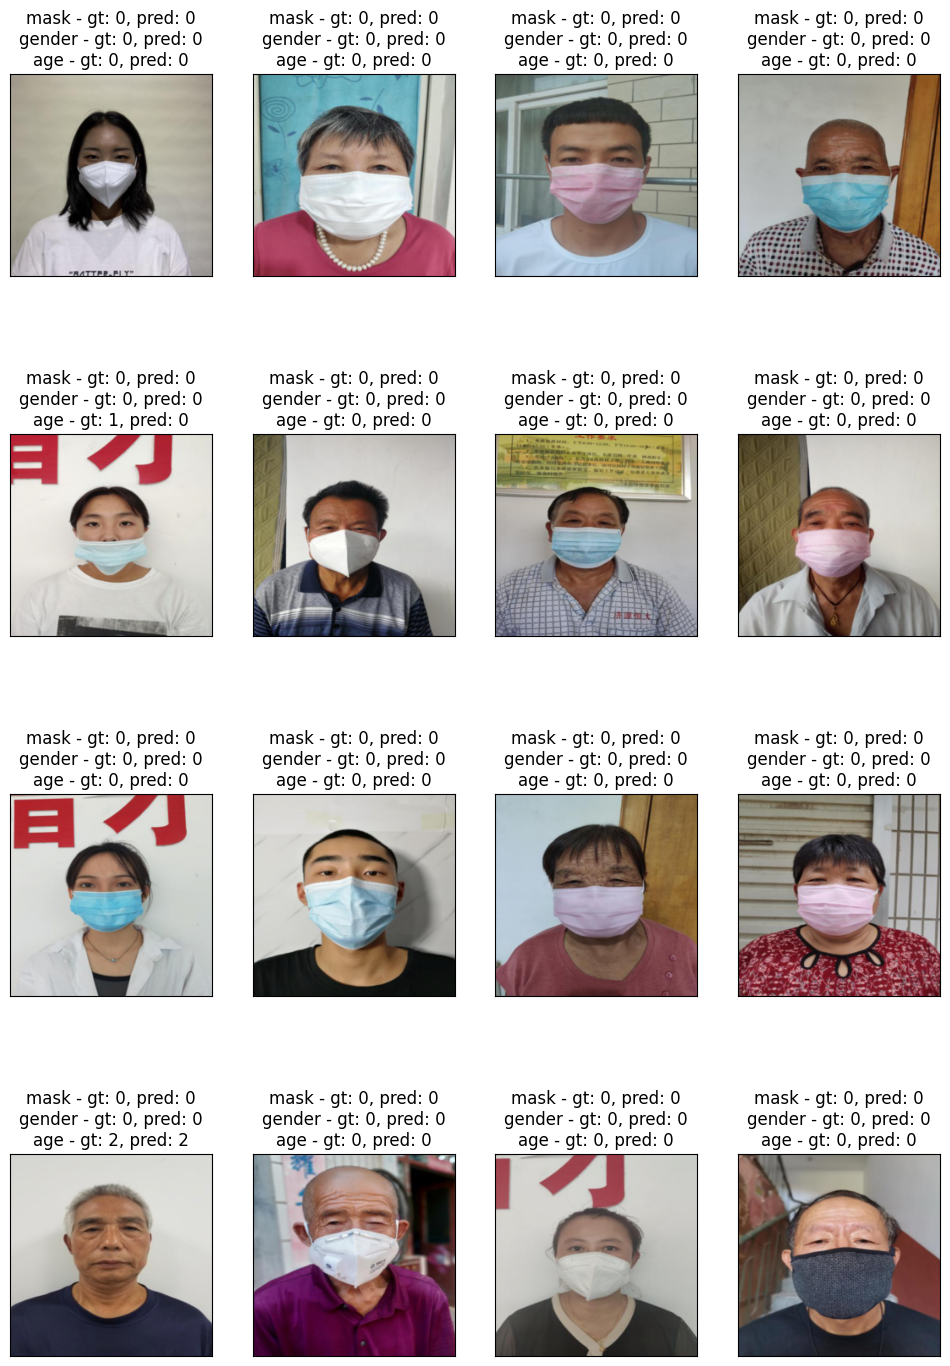

In [11]:
for epoch in range(10):
    # train loop
    model.train()
    loss_value = 0
    matches = 0
    for idx, train_batch in enumerate(train_loader):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)

        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds == labels).sum().item()
        if (idx + 1) % 20 == 0:
            train_loss = loss_value / 20
            train_acc = matches / 64 / 20
            current_lr = get_lr(optimizer)
            print(
                f"Epoch[{epoch}/{10}]({idx + 1}/{len(train_loader)}) || "
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
            )
            logger.add_scalar(
                "Train/loss", train_loss, epoch * len(train_loader) + idx
            )
            logger.add_scalar(
                "Train/accuracy", train_acc, epoch * len(train_loader) + idx
            )

            loss_value = 0
            matches = 0

    scheduler.step()

    # val loop
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()
        val_loss_items = []
        val_acc_items = []
        figure = None
        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

            if figure is None:
                inputs_np = (
                    torch.clone(inputs).detach().cpu().permute(0, 2, 3, 1).numpy()
                )
                inputs_np = dataset_module.denormalize_image(
                    inputs_np, dataset.mean, dataset.std
                )
                figure = grid_image(
                    inputs_np,
                    labels,
                    preds,
                    n=16,
                    shuffle=MaskBaseDataset != "MaskSplitByProfileDataset",
                )

        val_loss = np.sum(val_loss_items) / len(val_loader)
        val_acc = np.sum(val_acc_items) / len(val_set)
        best_val_loss = min(best_val_loss, val_loss)
        if val_acc > best_val_acc:
            print(
                f"New best model for val accuracy : {val_acc:4.2%}! saving the best model.."
            )
            torch.save(model.module.state_dict(), f"{save_dir}/best.pth")
            best_val_acc = val_acc
        torch.save(model.module.state_dict(), f"{save_dir}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
        logger.add_scalar("Val/loss", val_loss, epoch)
        logger.add_scalar("Val/accuracy", val_acc, epoch)
        logger.add_figure("results", figure, epoch)
        print()